In [1]:
import os
import math
from typing import Optional, Dict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy
import numpy as np

from pandas import DataFrame

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

class Metric:
    name: str
    abbreviation: str
    unit: Optional[str]

    def __init__(self, name: str, abbreviation: str, unit: Optional[str]) -> None:
        self.name = name
        self.abbreviation = abbreviation
        self.unit = unit

    def __str__(self) -> str:
        base = f"{self.name} ({self.abbreviation})"

        if self.unit:
            return f"{base} [{self.unit}]"
        else:
            return base

OUT_DIR = "output"

if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

APPLICATIONS = {
    "postgresql-ha": "PostgreSQL",
    "redis": "Redis",
    # "redis-cluster": "Redis Cluster,
}
EXPERIMENTS = {
    "ct": "Control Test",
    "pd": "Perturbation Disabled",
    "vb": "Vary Build",
    "vp": "Vary Patch",
    "vm": "Vary Minor",
}
EXPERIMENTS_ORDER = { value: index for index, value in enumerate(EXPERIMENTS.keys()) }
EXPERIMENTS_NAME_ORDER = { EXPERIMENTS[experiment]: EXPERIMENTS_ORDER[experiment] for experiment in EXPERIMENTS_ORDER.keys()}
METRICS: Dict[str, Metric] = {
    "time_to_initialize": Metric(
        name="Time to Complete Initialization",
        abbreviation="TCI",
        unit="s",
        ),
    "time_to_first_request": Metric(
        name="Time to First Request",
        abbreviation="TFR",
        unit="s",
    ),
    "time_to_all_requests": Metric(
        name="Time to All Containers Handle Requests",
        abbreviation="TACHR",
        unit="s",
    ),
    "restarts": Metric(
        name="Amount of Container Restarts",
        abbreviation="ACR",
        unit=None,
    ),
}
TIME_BASED_METRICS: Dict[str, Metric] = {index: metric for index,metric in filter(lambda x: x[1].unit == "s", METRICS.items())}

In [2]:
# Import all data

try:
    # Use the current file as the base-path
    base_path = os.path.dirname(__file__)
except NameError:
    # Fall back to the current directory if it is not available,
    # is it means that we are in interactive mode.
    base_path = "."


# Read all datafiles as separate DataFrames
dfs = {
    (application_name, experiment): pd.read_json(path, lines=True)
    if os.path.isfile(path := os.path.join(base_path, "..", "results", f"{experiment}_{application}.jsonl")) else None
    for experiment in EXPERIMENTS.keys()
    for application, application_name in APPLICATIONS.items()
}

# Combine all DataFrames
df = pd.concat(dfs, names=["Application", "experiment"])

# Adds the experiment and application index as a column
df.reset_index(level=[0, 1], inplace=True)

# Adds a human readable experiment name column
df["Experiment Type"] = df["experiment"].apply(lambda x: EXPERIMENTS[x])


In [3]:
# Define methods to make and store plots

def save_plot(name: str):
    for file_type in ["pdf", "png", "jpg", "svg"]:
        plt.savefig(os.path.join(OUT_DIR, f"{name}.{file_type}"),
                    transparent=True,
                    bbox_inches='tight'
                    )

def show_plot(data: DataFrame, x: str, y: str, xlabel: str, ylabel: str, hue: Optional[str] = None) -> None:
    sns.set(style="ticks")

    f, ax = plt.subplots(figsize=(12, 3))

    sns.boxplot(data=data,
                x=x,
                y=y,
                hue=hue,
                )

    sns.swarmplot(data=data,
                  x=x,
                  y=y,
                  size=3,
                  hue=hue,
                  alpha=0.5,
                  )

    ax.xaxis.grid(True)
    ax.set_xlim(xmin=-1,)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

# All Raw Data

In [4]:
# Display the data loaded
df

,Application,experiment,start_time,time_to_initialize,time_to_first_request,time_to_all_requests,restarts,end_time,Experiment Type
0,PostgreSQL,ct,2020-08-10 14:05:56.242291927,78.602810,45.747801,70.021016,0,2020-08-10 14:07:15.298298836,Control Test
1,PostgreSQL,ct,2020-08-10 14:14:43.314725161,45.677756,27.764674,34.111991,0,2020-08-10 14:15:29.429429054,Control Test
2,PostgreSQL,ct,2020-08-10 14:22:17.197078943,68.845743,42.068355,68.319220,0,2020-08-10 14:23:26.447458982,Control Test
3,PostgreSQL,ct,2020-08-10 14:29:47.296878099,65.700319,38.411755,61.599261,0,2020-08-10 14:30:53.454533815,Control Test
4,PostgreSQL,ct,2020-08-10 14:37:04.917234898,53.025109,24.400544,34.525423,0,2020-08-10 14:37:58.422300816,Control Test
5,PostgreSQL,ct,2020-08-10 14:45:00.511804818,59.683125,23.833006,32.322419,0,2020-08-10 14:46:00.655070066,Control Test
6,PostgreSQL,ct,2020-08-10 14:53:26.960787058,57.069379,27.461419,37.550996,0,2020-08-10 14:54:24.504987955,Control Test
7,PostgreSQL,ct,2020-08-10 15:10:44.283836842,65.758005,25.795390,38.214952,0,2020-08-10 15:11:50.535685062,Control Test
8,PostgreSQL,ct,2020-08-10 15:18:39.908933878,41.761491,26.440772,32.285831,0,2020-08-10 15:19:22.291574001,Control Test
9,PostgreSQL,ct,2020-08-10 15:25:34.384053946,42.127745,24.815127,35.697144,0,2020-08-10 15:26:16.970113993,Control Test


# Amount of Experiment Iterations

Shows the amount of times each experiment has been ran.

*Note: Redis does not have any results for "Vary Minor", as no suitable minor version is available to test with.*

In [5]:
# Create a pivot table to count the amount of experiment iterations
pivot = df.pivot_table(index="Experiment Type",
                       columns="Application",
                       values="restarts",
                       aggfunc=np.size,
                       fill_value="N/A",
                       margins=True,
                       margins_name="Total")

# Sort the rows of the pivot table based on the perturbation intensity of the experiments
sorted_index = sorted(pivot.index, key=lambda v: EXPERIMENTS_NAME_ORDER.get(v, math.inf))
pivot.reindex(sorted_index)

Application,PostgreSQL,Redis,Total
Experiment Type,,,
Control Test,50,50,100
Perturbation Disabled,50,50,100
Vary Build,15,15,30
Vary Patch,15,15,30
Vary Minor,15,N/A,15
Total,145,130,275


## Average Time to Initialize (TTI) and Amount of Restarts

In [6]:
df.groupby(["Experiment Type", "Application"], sort=False)\
    [["time_to_initialize", "restarts"]]\
    .mean()\
    .round(2)

time_to_initialize  restarts
Experiment Type       Application                              
Control Test          PostgreSQL                64.15      0.00
                      Redis                     38.65      0.00
Perturbation Disabled PostgreSQL                71.76      0.00
                      Redis                     43.25      0.00
Vary Build            PostgreSQL                64.17      0.00
                      Redis                     42.76      0.00
Vary Patch            PostgreSQL               134.51      3.87
                      Redis                     38.23      0.00
Vary Minor            PostgreSQL               514.18     10.47

# Control Test vs. Perturbation Disabled

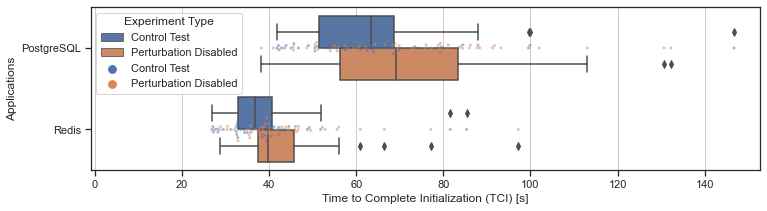

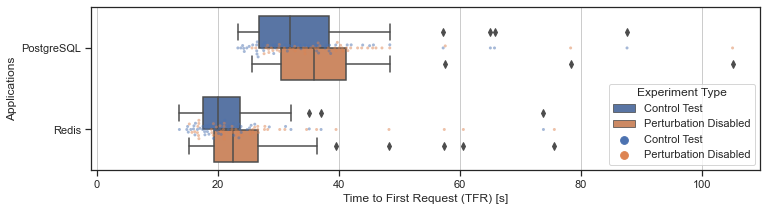

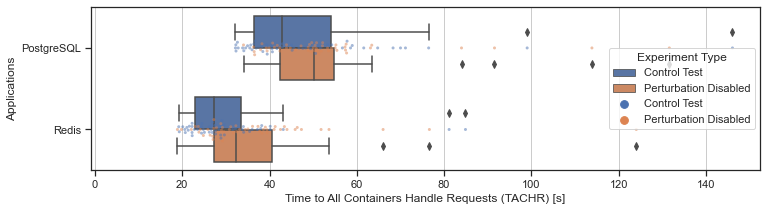

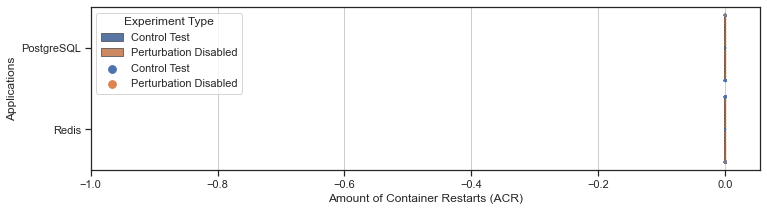

In [7]:
# Get all test results which are for the Control Test or Perturbation Disabled experiment types
df_pd_and_ct = df[(df.experiment.isin(["ct", "pd"]))]

# Show plots comparing the Control Test versus Perturbation Disabled
for metric in METRICS.keys():
    show_plot(data=df_pd_and_ct,
              x=metric,
              y="Application",
              xlabel=str(METRICS[metric]),
              ylabel="Applications",
              hue="Experiment Type"
              )
    save_plot(f"ct_vs_pd-{metric}")

## Difference in Deploy and Response time

In [8]:
# Pivot table showing the increase in response time
pivot = df_pd_and_ct.pivot_table(index="Experiment Type",
                                 values=TIME_BASED_METRICS.keys(),
                                 columns="Application",
                                 )

# Add rows with absolute and relative difference
pivot.loc["Absolute Difference"] = [
    pivot[column]["Perturbation Disabled"] - pivot[column]["Control Test"]
    for column in pivot.columns
]
pivot.loc["Relative Difference"] = [
    100.0 * pivot[column]["Absolute Difference"] / pivot[column]["Control Test"]
    for column in pivot.columns
]

# Round all results to two decimals
pivot = pivot.round(decimals=2)

# Append a percentage sign to the relative difference row
pivot.loc["Relative Difference"] = pivot.loc["Relative Difference"].apply(lambda v: f"{v}%")

# Replace metric headers to a human-friendly one
pivot.columns = pd.MultiIndex.from_tuples([(str(METRICS[c1]), c2) for c1, c2 in pivot.columns])

# Remove the name of the index to render more cleanly
pivot.index = pivot.index.set_names(None)

# Print the generated pivot table
pivot

Time to All Containers Handle Requests (TACHR) [s]  \
                                                              PostgreSQL   
Control Test                                                       48.75   
Perturbation Disabled                                              52.68   
Absolute Difference                                                 3.92   
Relative Difference                                                8.05%   

                              Time to First Request (TFR) [s]          \
                        Redis                      PostgreSQL   Redis   
Control Test            30.16                           35.34   22.09   
Perturbation Disabled   36.68                           38.48   26.02   
Absolute Difference      6.53                            3.15    3.93   
Relative Difference    21.64%                           8.91%  17.77%   

                      Time to Complete Initialization (TCI) [s]          
                                                     PostgreSQL   Redis  
Control Test                                              64.15   38.65  
Perturbation Disabled                                     71.76   43.25  
Absolute Difference                                        7.61    4.61  
Relative Difference                                      11.87%  11.92%

### Statistical Significance

Calculate the p-value for the hypothesis that the mean of the metric are the same between the Control Test and Perturbation Disabled. Welch's t-test is used, as not to assume that the variance is equal.

In [9]:
pvalues = pd.DataFrame(({
    "p-Value": scipy.stats.ttest_ind(*(df[(df.experiment == experiment) & (df.Application == application)][metric]
                                        for experiment in ("ct", "pd",)
                                       ),
                                      equal_var=True
                                      ).pvalue,
    "Metric": str(METRICS[metric]),
    "Application": application,
    }
for metric in TIME_BASED_METRICS.keys()
for application in ("PostgreSQL", "Redis")
))

pvalues.pivot("Metric", "Application")

p-Value          
Application                                        PostgreSQL     Redis
Metric                                                                 
Time to All Containers Handle Requests (TACHR) [s]   0.300372  0.030039
Time to Complete Initialization (TCI) [s]            0.053723  0.048184
Time to First Request (TFR) [s]                      0.219115  0.066115

### Combined
These p-values can be combined using the Fisher's method, which yields a combined probabilty of:

In [10]:
(_, combined_pvalue) = scipy.stats.combine_pvalues(pvalues["p-Value"])

combined_pvalue

0.0029943339738053836

# Impact of Perturbation on the Collected Metrics

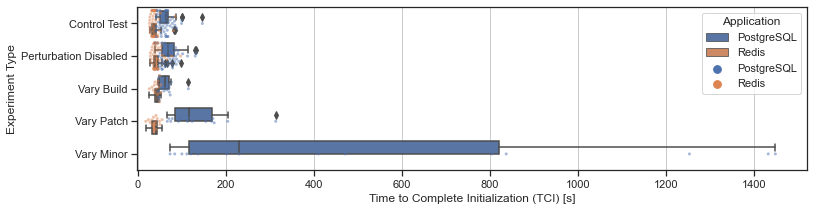

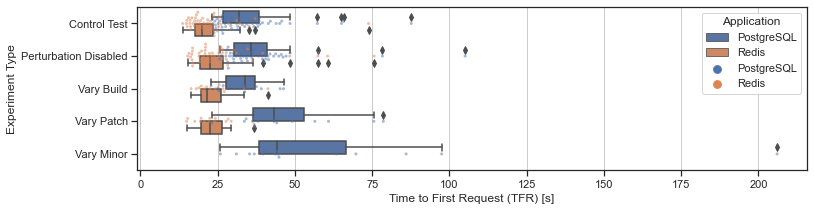

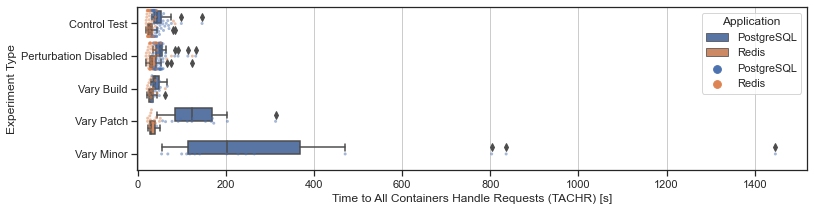

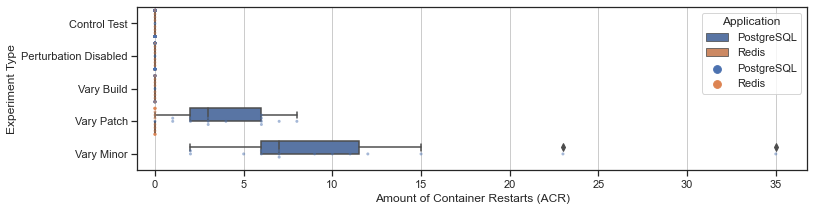

In [11]:
for metric in METRICS.keys():
    show_plot(data=df,
              x=metric,
              y="Experiment Type",
              xlabel=str(METRICS[metric]),
              ylabel="Experiment Type",
              hue="Application"
              )
    save_plot(f"box_and_scatter_plot-{metric}")